In [41]:
import sys
import hashlib
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("..")

from itertools import product

from opdynamics.simulation.simulation import initialize_model
from opdynamics.utils.model_modification import modify_model
from opdynamics.utils.types import Parameters

In [23]:
def param_to_hash(params: tuple) -> str:
    param_tuple = params
    string = str(param_tuple).encode("utf-8")
    return str(hashlib.sha256(string).hexdigest())

In [39]:
def get_path(params: tuple, experiments_path: str) -> str:
    exp_path = f"{experiments_path}/{param_to_hash(params)}"
    return exp_path

def get_runs(path: str):
    return [f"{path}/{x}" for x in os.listdir(path) if "pkl" in x and "run" in x]
    
def get_mean_run_stats(runs_path: str, T: int) -> dict:
    try:
        runs = get_runs(runs_path)
    except Exception as e:
        raise(e)
        
    mean_run_stats = {
        "Entropy": np.zeros(T),
        "Proximity": np.zeros(T),
        "Polarity": np.zeros(T),
        "Distribution": np.zeros((32, T))
    }
    
    num_runs = len(runs)
    
    for run in runs:
        stats = pickle.load(open(run, "rb"))
        mean_run_stats['Entropy'] += stats['Entropy']
        mean_run_stats['Proximity'] += stats['Proximity']
        mean_run_stats['Polarity'] += stats['Polarity']
        mean_run_stats['Distribution'] += np.array(stats['Distribution']).T
            
    mean_run_stats['Entropy'] /= num_runs
    mean_run_stats['Proximity'] /= num_runs
    mean_run_stats['Polarity'] /= num_runs
    mean_run_stats['Distribution'] /= num_runs
    
    return mean_run_stats

def get_mean_stats(param_list: dict, experiment_path: str, T: int) -> dict:
    mean_stats = {}
    
    params = list(product(*param_list.values()))
    for param in params:
        run_path = get_path(param, experiment_path)
        mean_stats[param] = get_mean_run_stats(run_path, T)
        
    return mean_stats

In [24]:
param_list = {
    "graph_type": ["barabasi"],
    "network_size": [500],
    "memory_size": [256],
    "code_length": [5],
    "kappa": [0, 15, 30],
    "lambd": [0, 0.1, 1],
    "alpha": [0.2, 0.4, 0.6],
    "omega": [0.2, 0.4], 
    "gamma": [-1, 0, 1],
    "preferential_attachment": [2],
    "polarization_grouping_type": [0],
    "T": [500],
    "num_repetitions": [500],
    "early_stop": [True],
    "epsilon": [1e-7],
    "results_path": ["results/experiment_2/"]
}

experiments_path = "../results/experiment_2"

In [40]:
mean_stats = get_mean_stats(param_list, experiments_path, 500)

***

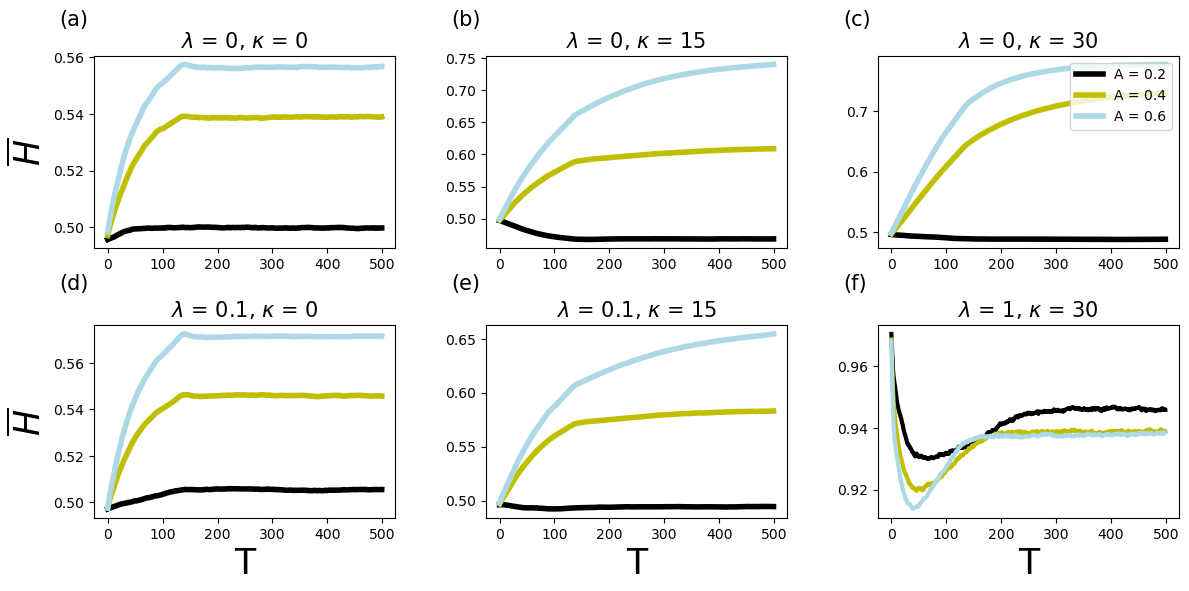

In [50]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (14, 6))
fig.subplots_adjust(hspace = 0.4, wspace = 0.30)
for ax in axs[1]:
    ax.set_xlabel("T", fontsize = 25)

for k in [0, 1]:
    axs[k][0].set_ylabel(r"$\overline{H}$", fontsize = 25)
    
# axs[0, 0].set_ylim([3.5, 5])
# axs[0, 1].set_ylim([0, 5])
# axs[0, 2].set_ylim([0, 5])
# axs[1, 0].set_ylim([3.5, 5])
# axs[1, 1].set_ylim([0, 5])
# axs[1, 2].set_ylim([3.25, 5])

fig.text(0.10, 0.93, "(a)", fontsize = 15)
fig.text(0.38, 0.93, "(b)", fontsize = 15)
fig.text(0.66, 0.93, "(c)", fontsize = 15)
fig.text(0.10, 0.49, "(d)", fontsize = 15)
fig.text(0.38, 0.49, "(e)", fontsize = 15)
fig.text(0.66, 0.49, "(f)", fontsize = 15)
    
colors = {
    1: "purple",
    0.8: "darkgreen",
    0.6: "lightblue",
    0.4: "y",
    0.2: "k"
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

kappas = [0, 15, 30]
lambdas = [0, 0.1]
alpha = [0.2, 0.4, 0.6]

for i in range(len(alpha)):
    for j in range(len(kappas)):
        for k in range(len(lambdas)):
            if j == 2 and k == 1:
                pass
            else:
                param = (
                    "barabasi",
                    500,
                    256,
                    5,
                    kappas[j],
                    lambdas[k],
                    alpha[i],
                    0.2,
                    0,
                    2,
                    0,
                    500,
                    500,
                    True,
                    1e-7,
                    "results/experiment_2/"
                )
                
                results = mean_stats[param]
                mean_entropy = results['Polarity']
                X = range(len(mean_entropy))
                
                axs[k][j].plot(X, mean_entropy, label = f'A = {alpha[i]}', color = colors[alpha[i]], linewidth = 4)

                axs[k][j].set_title(rf"$\lambda$ = {lambdas[k]}, $\kappa$ = {kappas[j]}", fontsize = 15)
                
for i in range(len(alpha)):
    param = (
        "barabasi",
        500,
        256,
        5,
        30,
        1,
        alpha[i],
        0.2,
        0,
        2,
        0,
        500,
        500,
        True,
        1e-7,
        "results/experiment_2/"
    )

    results = mean_stats[param]
    mean_entropy = results['Proximity']
    X = range(len(mean_entropy))

    axs[1][2].plot(X, mean_entropy, label = f'A = {alpha[i]}', color = colors[alpha[i]], linewidth = 3)

    axs[1][2].set_title(rf"$\lambda$ = {1}, $\kappa$ = {30}", fontsize = 15)    

axs[0][2].legend(fontsize = 10, loc = 1)